[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MusicalInformatics/miws2024/blob/main/alignment/DTW_tutorial.ipynb)

# A short tutorial on Dynamic Time Warping

This notebook contains a small introduction to Dynamic Time Warping (DTW).


In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install python packages
    # Issues on Colab with newer versions of MIDO
    ! pip install mido==1.2.10
    ! pip install partitura
    ! pip install fastdtw

    # To be able to access helper modules in the repo for this tutorial
    # (not necessary if the jupyter notebook is run locally instead of google colab)
    !git clone https://github.com/neosatrapahereje/music_alignment_tutorial
    import sys
    sys.path.insert(0, "./music_alignment_tutorial/")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from helper import  generate_example_sequences, plot_alignment

from typing import List

%config InlineBackend.figure_format ='retina'


DTW is a [dynamic programming algorithm](https://en.wikipedia.org/wiki/Dynamic_programming) to find the **optimal** alignment between to time-dependent sequences. Unlike Euclidean distance, which requires point-to-point correspondence between two sequences, DTW allows for elastic transformations of the time axis, enabling it to find an optimal match between two sequences that may vary in time.

The DTW algorithm finds the alignment between two sequence in three steps:

1. Compute $\mathbf{C}$, the pairwise distance matrix between elements in sequence $\mathbf{X}$ and $\mathbf{Y}$.

$$\mathbf{C}[i,j] = \text{dist}(\mathbf{x}_i, \mathbf{y}_j)$$

for $\mathbf{x}_i \in \mathbf{X}$ and $\mathbf{y}_i \in \mathbf{Y}$

2. Compute the accumulated cost matrix $\mathbf{D}$. The element $\mathbf{D}[i,j]$ represents the "cost" required for $x_i$ and $y_j$ to be aligned. Following a dynamic programming approach, the element $\mathbf{D}[i,j]$ can be computed recursively using the following equation:

$$\mathbf{D}[i,j] = \mathbf{C}[i,j] + \min \left\{\mathbf{D}[i-1, j-1], \mathbf{D}[i-1, j], \mathbf{D}[i, j-1] \right\}$$

3. Find the best alignment by backtracking over $\mathbf{D}$

For now, let us generate some test data that we can play with!

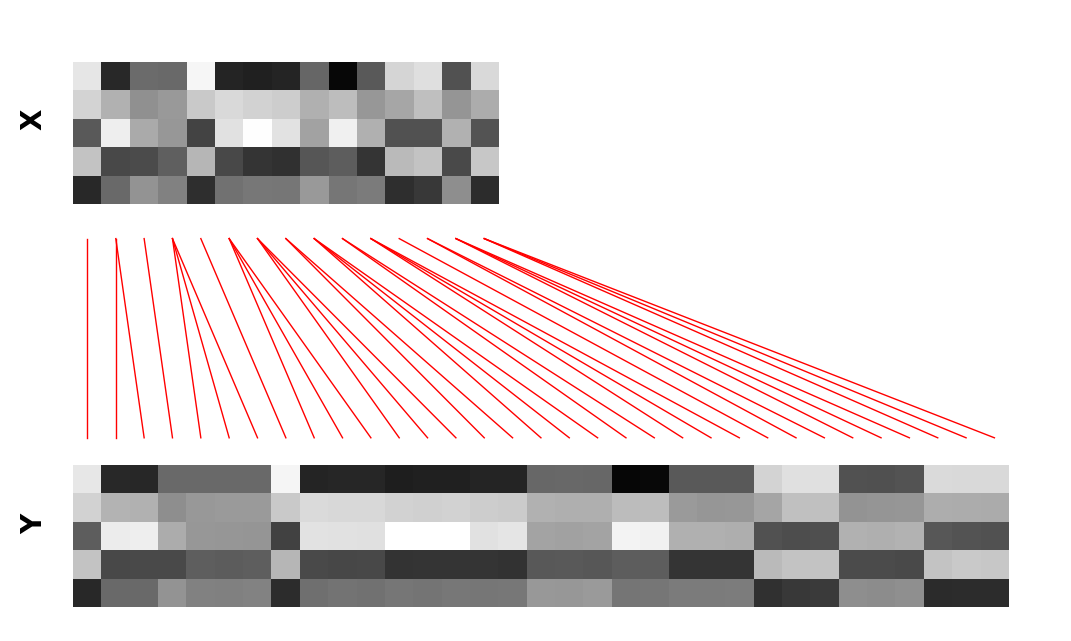

In [3]:
# This is a helper method to generate sample sequences
# (see helper.py for documentation)

# lenght of the "reference" sequence
lenX = 15

# dimensionality of the feature space
K = 5

# This method generates an example sequence
X, Y, gr_path = generate_example_sequences(
    lenX=lenX,
    centers=3,
    n_features=K,
    maxreps=4,
    minreps=1,
    noise_scale=0.1,
)

# Let us plot the data to see how it looks like!
plot_alignment(X, Y, gr_path)

## Comparing the similarity of the features: Local cost distance

We would like to know how to compare the elements in $\mathbf{X}$ and $\mathbf{Y}$. For this we use a local distance function, which can be any distance(-like) function that is small when $\mathbf{x}_i$ is *similar* to $\mathbf{y}_j$.

Which distance to use depends on the problem at hand, although usual starting points are the Euclidean and the Manhattan ($L_1$) distances.

Using this local distance, we can compare the elements in both sequences by comparing the pairwise distance of all elements in $\mathbf{X}$ and $\mathbf{Y}$. This will result in a matrix $\mathbf{C}$, where the element $\mathbf{C}[i,j]$ is given by

$$\mathbf{C}[i,j] = \text{distance}(\mathbf{x}_i, \mathbf{y}_j)$$

Let's visualize the pairwise cost matrix. 

(See metrics implemented in [scipy.spatial.distance](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html))

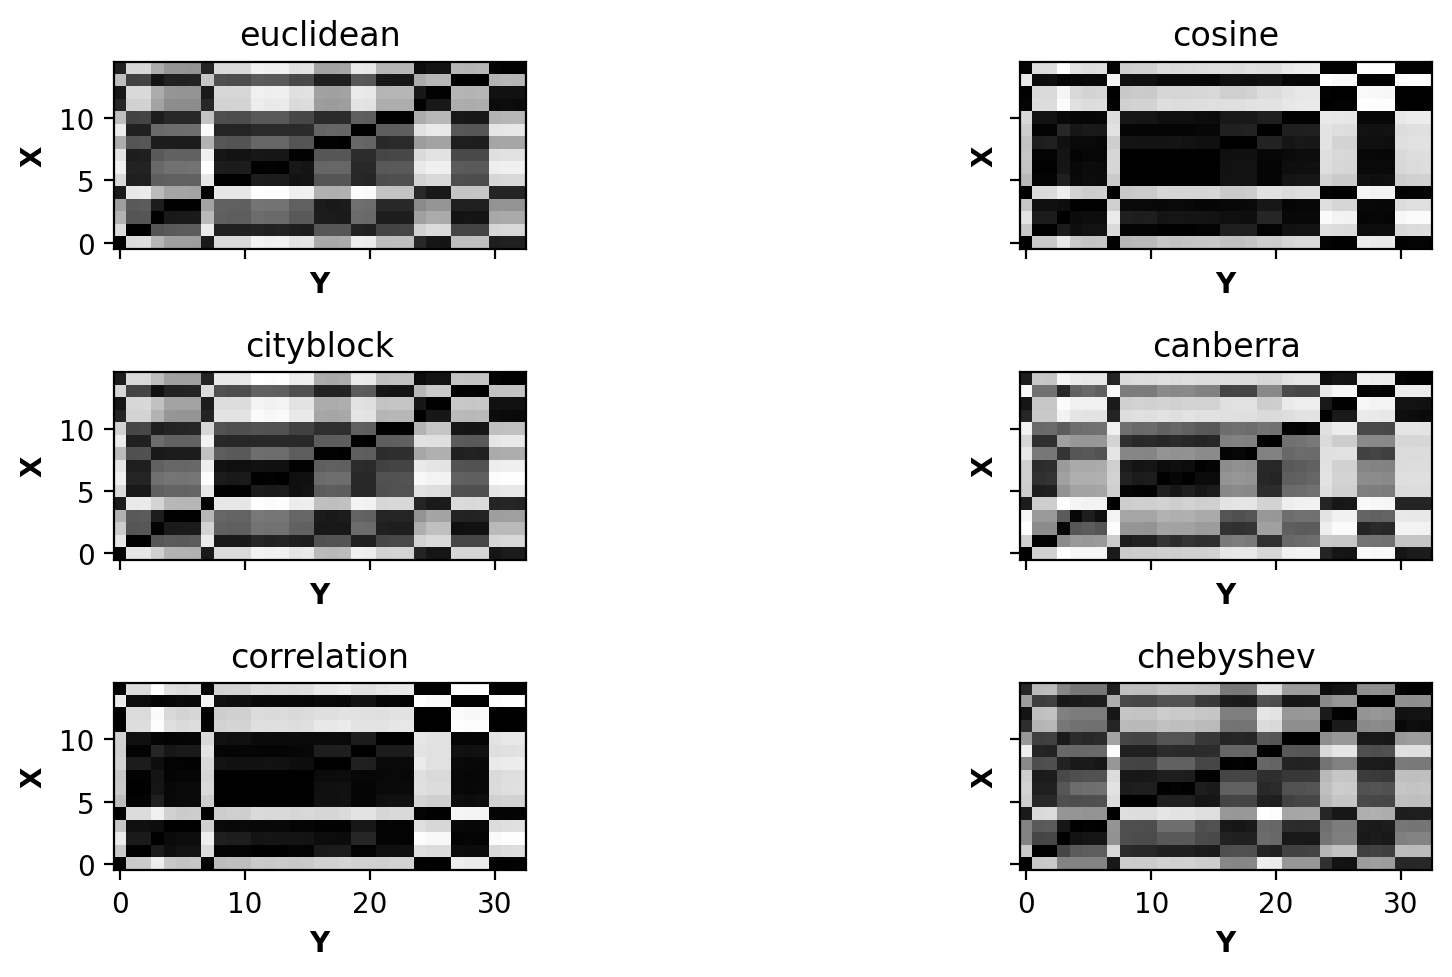

In [4]:
from alignment import (
    pairwise_distance_matrix,
    accumulated_cost_matrix,
    optimal_warping_path,
)

# Metrics to consider
# You can explore more possbilities in
# https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
metrics = ["euclidean", "cosine", "cityblock", "canberra", "correlation", "chebyshev"]

n_rows = int(np.ceil(np.sqrt(len(metrics))))
n_columns = int(np.ceil(len(metrics) / n_rows))
fig, axes = plt.subplots(n_rows, n_columns, sharex=True, sharey=True, figsize=(10, 5))

for i in range(n_rows):
    for j in range(n_columns):
        mix = i * n_columns + j

        if mix < len(metrics):
            # Compute pairwise distance matrix
            C = pairwise_distance_matrix(X, Y, metric=metrics[mix])
            # Plot matrix
            axes[i, j].imshow(C, origin="lower", aspect="equal", cmap="gray")
            axes[i, j].set_xlabel(r"$\mathbf{Y}$")
            axes[i, j].set_ylabel(r"$\mathbf{X}$")
            axes[i, j].set_title(metrics[mix])

plt.tight_layout()
plt.show()

## Computing the accumulated cost

An intuitive description of matrix $\mathbf{D}$, the accumulated cost matrix in DTW, can be likened to a map that charts the journey between sequences $\mathbf{X}$ and $\mathbf{Y}$, where each element $x$ in $\mathbf{X}$ wishes to visit an element in $\mathbf{Y}$. Each cell in $\mathbf{D}$ represents a specific meeting point between a member of sequence $\mathbf{X}$ and a member of sequence $\mathbf{Y}$, and the value in each cell reflects the "cost" or "effort" required for them to meet.

* **Input**: Cost matrix $\mathbf{C}$ of size $N \times M$
* **Output**: $d_{DTW}$

**Procedure**

1. Initialize $N \times M$ matrix $D$ (accumulated cost) by

$$\mathbf{D}[n, 0] = \sum_{k=0}^{n} \mathbf{C}[k, 0]$$

for $n \in [0,N-1]$, and

$$\mathbf{D}[0, m] = \sum_{k=0}^{m} \mathbf{C}[0, k]$$

for $n \in [0, M-1]$

2. Compute in a nested loop for $n=1,\dots, N-1$ and $m=1, \dots, M-1$

$$\mathbf{D}[n, m] = \mathbf{C}[n, m] + \min \left\{\mathbf{D}[n-1, m-1], \mathbf{D}[n-1, m], \mathbf{D}[n, m-1] \right\}$$

3. The dynamic time warping distance is given by

$$d_{DTW}(\mathbf{X}, \mathbf{Y}) = \mathbf{D}[N-1, M-1]$$

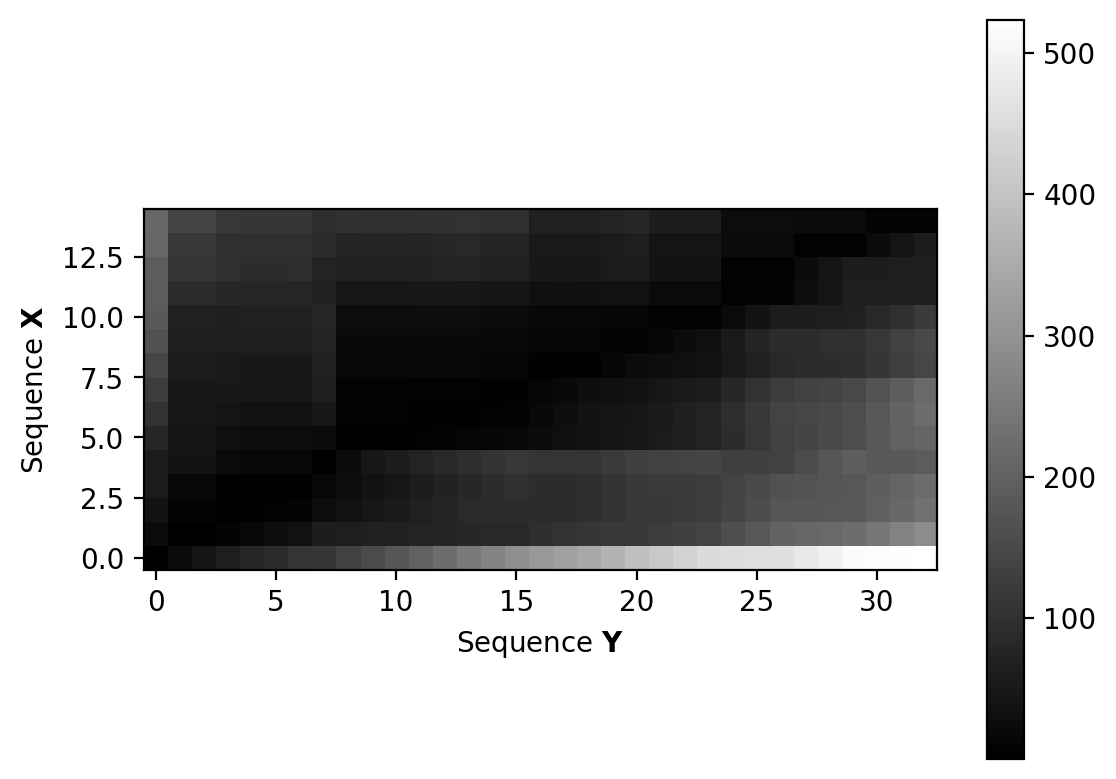

In [5]:
C = pairwise_distance_matrix(X, Y, metric="euclidean")
D = accumulated_cost_matrix(C)

# Visualize accumulated cost matrix
plt.imshow(D, origin="lower", aspect="equal", cmap="gray")
plt.xlabel(r"Sequence $\mathbf{Y}$")
plt.ylabel(r"Sequence $\mathbf{X}$")
plt.colorbar()
plt.show()

## Compute Optimal Path

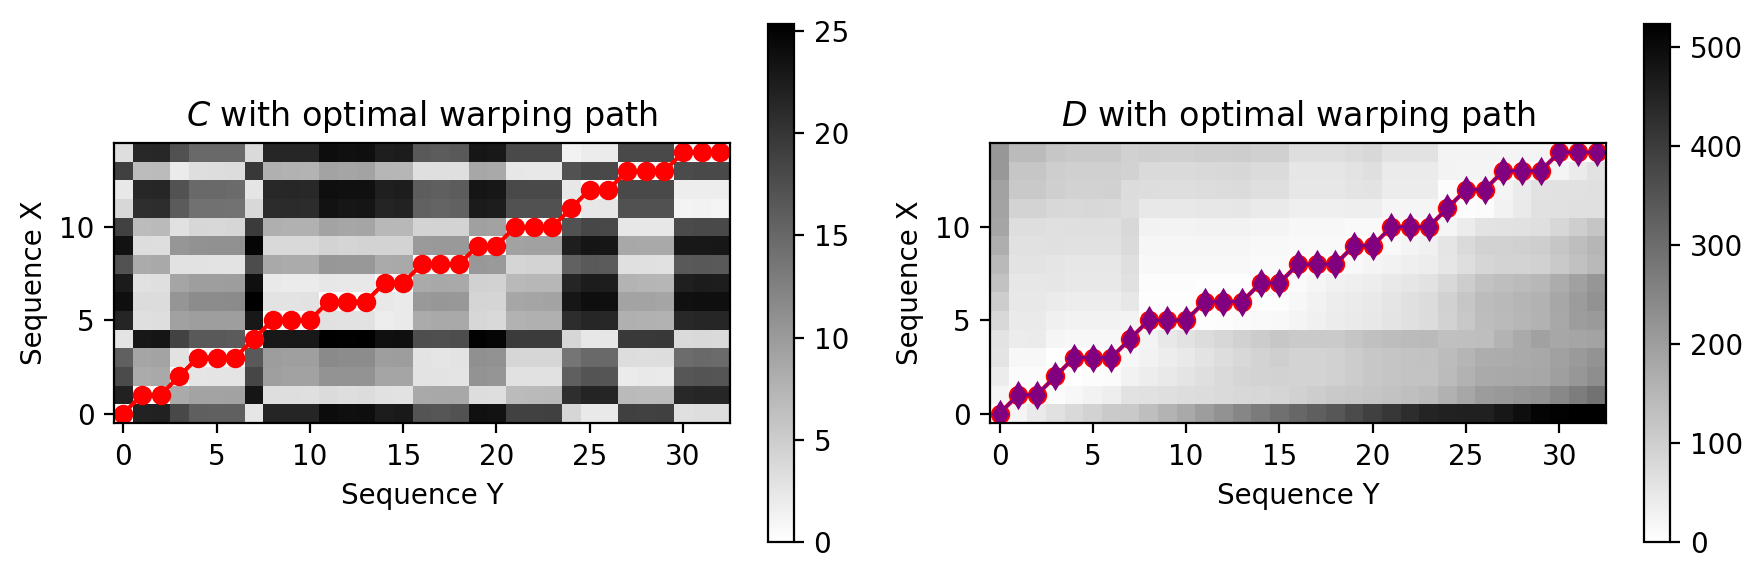

In [6]:
P = optimal_warping_path(D)

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(C, cmap="gray_r", origin="lower", aspect="equal")
plt.plot(P[:, 1], P[:, 0], marker="o", color="r")
plt.clim([0, np.max(C)])
plt.colorbar()
plt.title("$C$ with optimal warping path")
plt.xlabel("Sequence Y")
plt.ylabel("Sequence X")

plt.subplot(1, 2, 2)
plt.imshow(D, cmap="gray_r", origin="lower", aspect="equal")
plt.plot(P[:, 1], P[:, 0], marker="o", color="r")
plt.plot(gr_path[:, 1], gr_path[:, 0], marker="d", color="purple", linewidth=1.1)
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title("$D$ with optimal warping path")
plt.xlabel("Sequence Y")
plt.ylabel("Sequence X")

plt.tight_layout()

This naive implementation is very slow! You can only use it for aligning small sequences. For practical stuff, we are going to use the `fasdtw` package. This package contains an efficient implementation of vanilla DTW, as well as a faster approximation, called FastDTW.

In [7]:
from alignment import dynamic_time_warping, fast_dynamic_time_warping
import time

for lenX in [10, 100, 1000]:
    X, Y, gr_path = generate_example_sequences(
        lenX=lenX, centers=3, n_features=K, maxreps=2, minreps=2, noise_scale=0.1
    )
    st = time.process_time()
    path_naive, dtwd_naive = dynamic_time_warping(X, Y, return_distance=True)
    et_naive = time.process_time() - st

    st = time.process_time()
    path_fdtw, dtwd_fdtw = fast_dynamic_time_warping(X, Y, return_distance=True)
    et_fdtw = time.process_time() - st

    print(f"Input sizes: X:{X.shape} Y:{Y.shape}")
    print(f"\tDTW: {dtwd_naive:.3f} ({et_naive * 1000:.2f} ms)")
    print(f"\tFastDTW: {dtwd_fdtw:.3f} ({et_fdtw * 1000:.2f} ms)")

Input sizes: X:(10, 5) Y:(20, 5)
	DTW: 3.725 (0.14 ms)
	FastDTW: 3.725 (2.10 ms)
Input sizes: X:(100, 5) Y:(200, 5)
	DTW: 43.119 (20.60 ms)
	FastDTW: 43.119 (19.94 ms)
Input sizes: X:(1000, 5) Y:(2000, 5)
	DTW: 427.196 (927.79 ms)
	FastDTW: 427.196 (78.10 ms)
